# Case-by-case analysis
This notebook demonstrates how to visualize which model managed to solve which test-case how often.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
directory = "../data/"
categories_file = "../data/human-eval-bia-categories.yaml"

collection = []
for filename in os.listdir(directory):
    if filename.endswith("_results.jsonl"):
        print(filename)
        df = pd.read_json(directory + filename, lines=True)
        df['model'] = filename.replace(".jsonl_results.jsonl", "").replace("samples_", "")
        collection.append(df)

df = pd.concat(collection)

samples_reference.jsonl_results.jsonl


In [3]:
df.head()

,task_id,completion,full_response,result,passed,model
0,../test_cases/apply_otsu_threshold_and_count_p...,\n import skimage\n import numpy as np\n...,\n import skimage\n import numpy as np\n...,passed,True,reference
1,../test_cases/binary_closing.ipynb,\n import numpy as np\n import skimage\n...,\n import numpy as np\n import skimage\n...,passed,True,reference
2,../test_cases/binary_skeleton.ipynb,\n from skimage.morphology import skeletoni...,\n from skimage.morphology import skeletoni...,passed,True,reference
3,../test_cases/bland_altman.ipynb,\n import scipy\n data1 = dataframe[colu...,\n import scipy\n data1 = dataframe[colu...,passed,True,reference
4,../test_cases/combine_columns_of_tables.ipynb,\n import pandas as pd\n return pd.merge...,\n import pandas as pd\n return pd.merge...,passed,True,reference


In [4]:
# Ensure the 'passed' column is boolean for correct processing.
df['passed'] = df['passed'].astype(bool)
# shorten task name
df['task_id'] = [str(t).replace("../test_cases/", "").replace(".ipynb","") for t in df['task_id']]

# Pivot the dataframe to count True 'passed' values for each model-task combination.
pivot_df = df.pivot_table(index='task_id', columns='model', values='passed', aggfunc='mean', fill_value=0)

# Reset the index if 'task_id' needs to be a column instead of an index
pivot_df.reset_index(inplace=True)

# Apply formatting to display only two digits after the decimal point for all columns after the first (task_id column)
pivot_df = pivot_df.round(2)

pivot_df

model,task_id,reference
0,apply_otsu_threshold_and_count_positive_pixels,1.0
1,binary_closing,1.0
2,binary_skeleton,1.0
3,bland_altman,1.0
4,combine_columns_of_tables,1.0
...,...,...
76,workflow_batch_process_folder_measure_intensity,1.0
77,workflow_segment_measure_umap,1.0
78,workflow_segmentation_counting,1.0
79,workflow_segmentation_measurement_summary,1.0


0.13.2


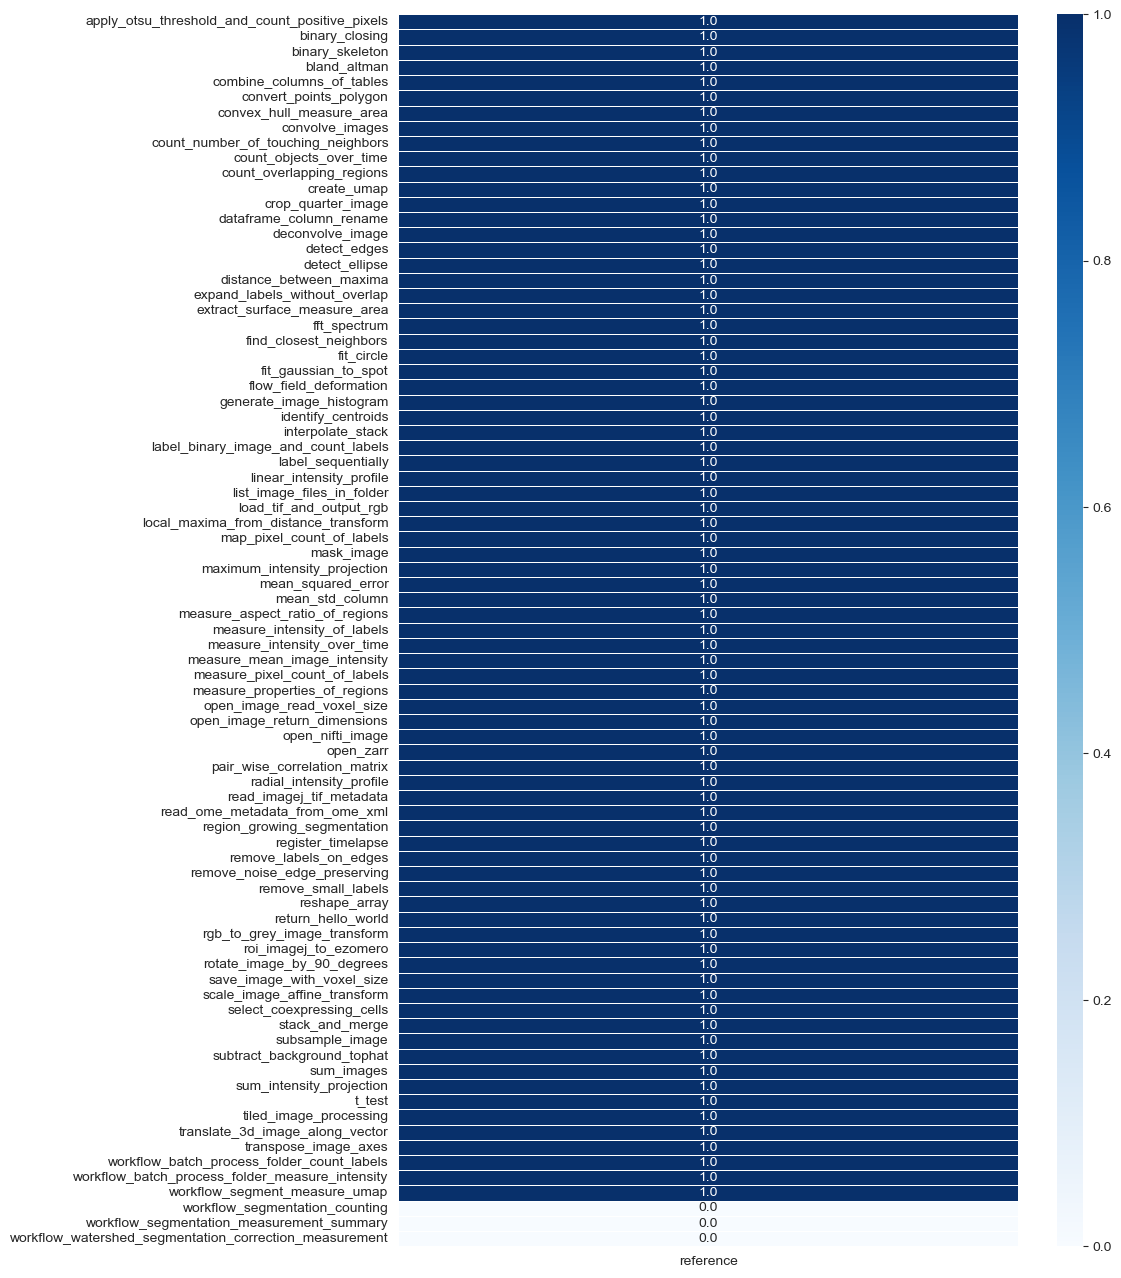

In [5]:
print(sns.__version__)
sns.set_style("white")

df_plot = pivot_df

# Separate the numerical data for plotting and the string column for y-axis labels
numerical_data = df_plot.select_dtypes(include=[np.number])
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
numerical_data = numerical_data[mean_values.index]

df_plot["average_task_score"] = df_plot.iloc[:,1:-1].mean(axis=1)
str_column_values = df_plot.sort_values(by="average_task_score", ascending=False)['task_id']  # Replace 'str_column' with the actual column name

# Plotting
fig = plt.figure(figsize=(10,16))
numerical_data["average_task_score"] = df_plot.iloc[:,1:-1].mean(axis=1)

sns.heatmap(numerical_data.sort_values("average_task_score",ascending=False).drop(columns=("average_task_score")), annot=True, linewidths=.5, yticklabels=str_column_values, fmt=".1f", cbar_kws={'shrink': 1, 'aspect': 3*16}, cmap="Blues")
plt.gca().set_xlabel('')

plt.savefig("../docs/paper/performance_per_task", bbox_inches="tight", dpi=300)
plt.show()

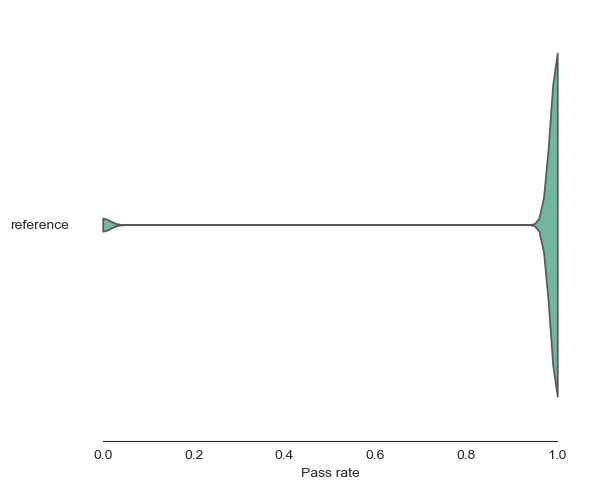

In [6]:
# Assuming pivot_df has 'task_id' as a non-numerical column and the rest are numerical and need to be plotted
numerical_data = pivot_df.drop(columns=['task_id']).drop(columns=("average_task_score"))

# Calculate the mean of each column and sort these means in descending order
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
ordered_numerical_data = numerical_data[mean_values.index]

# Plotting the boxplot with reordered columns and flipping the axes
plt.figure(figsize=(6, 5))
sns.violinplot(data=ordered_numerical_data, palette= "Set2", orient='h', cut=0, bw_adjust=0.2, inner=None)
sns.despine(offset=1, trim=True)

plt.yticks(rotation=0)  # Rotate y-axis labels if needed
plt.xlabel('Pass rate')  # Flip label to x-axis
plt.gca().set_ylabel('')  # Remove y-axis label
plt.tight_layout()  # Adjust layout to make room for the y-axis labels

plt.savefig("../docs/paper/pass_rate_llms.png", dpi=700)
plt.show()

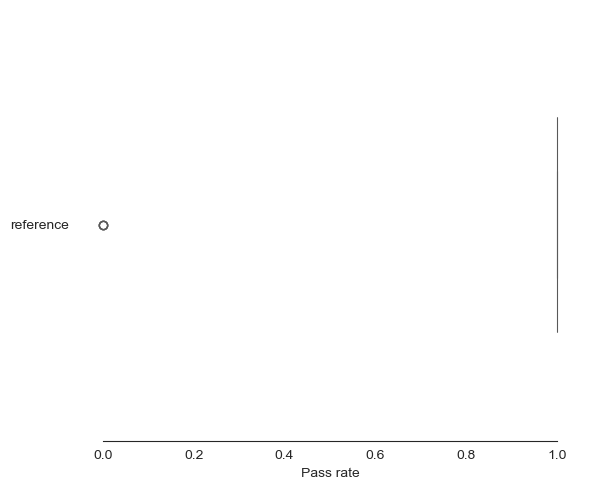

In [7]:
# Assuming pivot_df has 'task_id' as a non-numerical column and the rest are numerical and need to be plotted
numerical_data = pivot_df.drop(columns=['task_id']).drop(columns=("average_task_score"))

# Calculate the mean of each column and sort these means in descending order
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
ordered_numerical_data = numerical_data[mean_values.index]

# Plotting the boxplot with reordered columns and flipping the axes
plt.figure(figsize=(6, 5))
boxplot = sns.boxplot(data=ordered_numerical_data, palette= "Set2", width=0.5, linewidth=0.75, orient='h')
sns.despine(offset=1, trim=True)

plt.yticks(rotation=0)  # Rotate y-axis labels if needed
plt.xlabel('Pass rate')  # Flip label to x-axis
plt.gca().set_ylabel('')  # Remove y-axis label
plt.tight_layout()  # Adjust layout to make room for the y-axis labels

plt.savefig("../docs/paper/pass_rate_llms_old.png", dpi=700)
plt.show()

In [8]:
with open("model_order.txt", 'w') as f:
    for item in ordered_numerical_data.columns:
        f.write(str(item) + '\n')

Categorise functions and plot the functions by category

In [9]:
import yaml 

# Read YAML file with categorised tasks
with open(categories_file, 'r') as stream:
    category_function = yaml.safe_load(stream)


#swap key values in dict so list of values become keys and keys are values
function_category = {}
for category, functions in category_function.items():
    for function in functions:
        if function in function_category:
            function_category[function].append(category)
        else:
            function_category[function] = [category]
function_category


{'segmentation': ['apply_otsu_threshold_and_count_positive_pixels',
  'detect_edges',
  'region_growing_segmentation',
  'workflow_segment_measure_umap',
  'workflow_segmentation_counting',
  'workflow_segmentation_measurement_summary',
  'workflow_watershed_segmentation_correction_measurement',
  'detect_ellipse',
  'fit_gaussian_to_spot',
  'local_maxima_from_distance_transform'],
 'morphological_operations': ['binary_closing', 'binary_skeleton'],
 'statistical_analysis': ['bland_altman',
  'mean_squared_error',
  'mean_std_column',
  'pair_wise_correlation_matrix',
  't_test'],
 'data_wrangling': ['combine_columns_of_tables',
  'convert_points_polygon',
  'create_multipolygon_from_coordinates',
  'dataframe_column_rename',
  'roi_imagej_to_ezomero'],
 'feature_extraction': ['convex_hull_measure_area',
  'count_number_of_touching_neighbors',
  'create_umap',
  'measure_aspect_ratio_of_regions',
  'measure_intensity_of_labels',
  'measure_intensity_over_time',
  'measure_mean_image_in

In [10]:
#Create a new column in the dataframe with the name of the task_id
df['task_name'] = df["task_id"].apply(lambda x: x.split("/")[-1].replace(".ipynb", ""))

#Create a column for each category
#Each column will have a 1 if the function is in that category and 0  if not
#the task name is used to look up each task
for category in function_category.keys():
    df[category] = [1 if function in function_category[category] else 0 for function in df['task_name']]
df.head()


,task_id,completion,full_response,result,passed,model,task_name,segmentation,morphological_operations,statistical_analysis,data_wrangling,feature_extraction,measurement,image_filtering,image_transformation,segmentation_post_processing,file_i_o,image_preprocessing,hello_world,workflow_automation
0,apply_otsu_threshold_and_count_positive_pixels,\n import skimage\n import numpy as np\n...,\n import skimage\n import numpy as np\n...,passed,True,reference,apply_otsu_threshold_and_count_positive_pixels,1,0,0,0,0,0,0,0,0,0,0,0,0
1,binary_closing,\n import numpy as np\n import skimage\n...,\n import numpy as np\n import skimage\n...,passed,True,reference,binary_closing,0,1,0,0,0,0,0,0,0,0,0,0,0
2,binary_skeleton,\n from skimage.morphology import skeletoni...,\n from skimage.morphology import skeletoni...,passed,True,reference,binary_skeleton,0,1,0,0,0,0,0,0,0,0,0,0,0
3,bland_altman,\n import scipy\n data1 = dataframe[colu...,\n import scipy\n data1 = dataframe[colu...,passed,True,reference,bland_altman,0,0,1,0,0,0,0,0,0,0,0,0,0
4,combine_columns_of_tables,\n import pandas as pd\n return pd.merge...,\n import pandas as pd\n return pd.merge...,passed,True,reference,combine_columns_of_tables,0,0,0,1,0,0,0,0,0,0,0,0,0


In [11]:
#For each model, get the average passed rate for each category and create a new dataframe
category_results = {}

for category in function_category.keys():
    category_results[category] = df[df[category]==1].groupby(['model',category])['passed'].mean().reset_index(level=1, drop=True)

category_df = pd.DataFrame.from_dict(category_results,orient='index').reset_index().rename(columns={'index':'category'})

category_df.head()

,category,reference
0,segmentation,1.0
1,morphological_operations,1.0
2,statistical_analysis,1.0
3,data_wrangling,1.0
4,feature_extraction,1.0


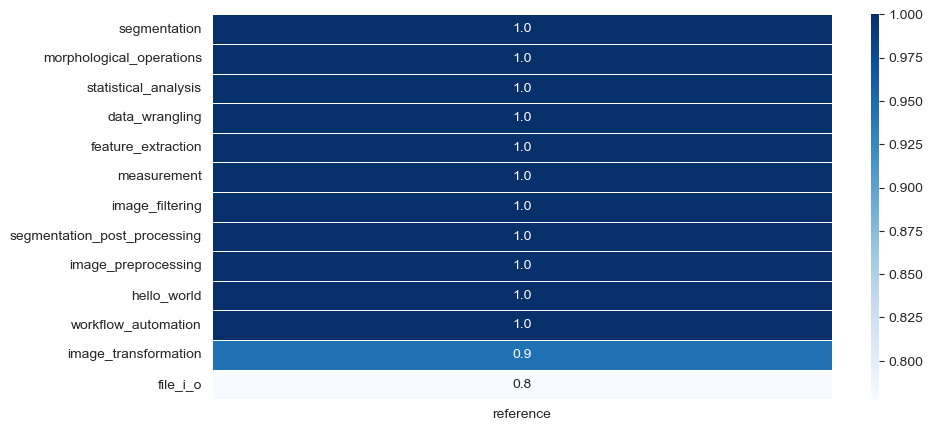

In [ ]:
df_category_plot = category_df.copy()

# Get the numerical data and sort the columns based on the mean values
numerical_df = df_category_plot.select_dtypes(include=[np.number])
mean_values = numerical_df.mean().sort_values(ascending=False)
# Reorder columns in numerical_data based on sorted mean values
numerical_data = numerical_df[mean_values.index]

#add a average task score column and sort by this column
df_category_plot["average_task_score"] = numerical_df.mean(axis=1)
df_category_plot.sort_values(by="average_task_score", ascending=False,inplace=True)
#column names for y axis labels
str_column_values = df_category_plot['category']  

#drop category and average task score as we don't need it for plotting
#we only need the model and the pass rate for each category
df_category_plot.drop(columns=["category","average_task_score"],inplace=True)

# Plotting
fig = plt.figure(figsize=(10,5))
#plot heatmap for average pass rate with category on y axis and model on x axis
sns.heatmap(df_category_plot, annot=True, linewidths=.5, yticklabels=str_column_values, fmt=".1f", cbar_kws={'shrink': 1, 'aspect': 3*16}, cmap="Blues")

plt.gca().set_xlabel('')

#save plot
plt.savefig("../docs/paper/performance_per_category", bbox_inches="tight", dpi=300)